# Imports

In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, concatenate, Dropout
from keras import backend as K
import os
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow as show
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam, SGD
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model Architecture

In [4]:
# Define input shape for the grayscale images (320x640 with 1 channel)
input_shape = (320, 640, 1)

# Define the input layers for the two images
input_1 = Input(shape=input_shape)
input_2 = Input(shape=input_shape)

# Define the Siamese network architecture
conv_net = Conv2D(64, (3, 3), activation='relu')

# Define the encoding layers for the first input image
encoded_1 = conv_net(input_1)
dropout_1 = Dropout(0.5)(encoded_1)
encoded_1 = MaxPooling2D(pool_size=(2, 2))(dropout_1)
encoded_1 = Conv2D(128, (3, 3), activation='relu')(encoded_1)
dropout_2 = Dropout(0.5)(encoded_1)
encoded_1 = MaxPooling2D(pool_size=(2, 2))(dropout_2)
encoded_1 = Flatten()(encoded_1)

# Define the encoding layers for the second input image
encoded_2 = conv_net(input_2)
dropout_3 = Dropout(0.5)(encoded_2)
encoded_2 = MaxPooling2D(pool_size=(2, 2))(dropout_3)
encoded_2 = Conv2D(128, (3, 3), activation='relu')(encoded_2)
dropout_4 = Dropout(0.5)(encoded_2)
encoded_2 = MaxPooling2D(pool_size=(2, 2))(dropout_4)
encoded_2 = Flatten()(encoded_2)

# Define the distance function for the Siamese network
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

# Apply the distance function to the encoded representations of the input images
distance = Lambda(euclidean_distance)([encoded_1, encoded_2])

# Define the output layer that predicts the intermediate frame
prediction = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(distance)

# Reshape the output to match the input image dimensions
prediction = Lambda(lambda x: K.reshape(x, (-1,) + input_shape[:2] + (1,)))(prediction)

# Create the Siamese model
siamese_model = Model(inputs=[input_1, input_2], outputs=prediction)

# Compile the model
siamese_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Print the model summary
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 320, 640, 1)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 320, 640, 1)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 318, 638, 64)         640       ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 318, 638, 64)         0         ['conv2d_3[0][0]']      

# Load Data

In [5]:
data_dir = '/content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Frame Interpolation'

# Function to save processed data
def save_data(data, filename):
    np.save(os.path.join(data_dir, filename), data)

# Function to load processed data
def load_data(filename):
    return np.load(os.path.join(data_dir, filename))

## Loading Images

In [6]:
# pngs_dir = "/content/drive/MyDrive/ENEE439D Group Project/Cloud Data /PNGs"
data_norm = load_data('data_norm.npy')

In [ ]:
# images = []
# for filename in os.listdir(pngs_dir):
#   if (filename.find("Masked") >= 0):
#     images.append(filename)

In [ ]:
# images.sort()
# data = []
# for name in images:
#   datapoint = cv2.imread(pngs_dir + "/" + name,0)
#   data.append(datapoint)

## Normalize the Data

In [ ]:
# # Convert 292x583 images into 320x640,1
# def resize_image (image):
#   return cv2.resize(image, (640,320))

In [ ]:
# data = np.array([resize_image(image) for image in data])
# data = np.expand_dims(data, axis=-1)

In [ ]:
# show(data[0])

In [ ]:
# data_norm = data/255

## Data vs Labels

In [7]:
start_frames = []
end_frames = []
labels = []

for i in range(len(data_norm) - 6):
  start_frames.append(data_norm[i])
  end_frames.append(data_norm[i+6])
  labels.append(data_norm[i+3])
  start_frames.append(data_norm[i])
  end_frames.append(data_norm[i+4])
  labels.append(data_norm[i+2])

data_in = np.stack((start_frames, end_frames), axis = 1)

data_in = np.array(data_in)
labels = np.array(labels)

In [8]:
test_size = 0.2
test_num = int(len(data_in) * test_size)
X_test = []
y_test = []
X_train = []
y_train = []
used = []

for i in range(test_num):
  index = np.random.randint(0, len(data_in))
  X_test.append(data_in[index])
  y_test.append(labels[index])
  used.append(index)

for i in range(len(data_in)):
  if (i not in used):
    X_train.append(data_in[i])
    y_train.append(labels[i])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# save_data(data_norm, 'data_norm.npy')
del labels
# del data
del data_in
del start_frames
del end_frames
gc.collect()

1559

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3255, 2, 320, 640, 1)
(798, 2, 320, 640, 1)
(3255, 320, 640, 1)
(798, 320, 640, 1)


# Training

In [16]:
checkpoint_path = '/content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Frame Interpolation/ Twin Model Mix'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [11]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [12]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss = 'binary_crossentropy'

In [13]:
siamese_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# history = siamese_model.fit([X_train[:, 0], X_train[:, 1]],
#                             y_train, epochs=10,
#                             batch_size= 10,
#                             callbacks=[cp_callback, es_callback],
#                             validation_split=0.2)

Epoch 1/10
262/262 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.8118
Epoch 1: saving model to /content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Frame Interpolation/ Twin Model Mix
262/262 [==============================] - 33s 93ms/step - loss: 0.3057 - accuracy: 0.8118 - val_loss: 0.4299 - val_accuracy: 0.8004
Epoch 2/10
261/262 [============================>.] - ETA: 0s - loss: 0.2152 - accuracy: 0.8553
Epoch 2: saving model to /content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Frame Interpolation/ Twin Model Mix
262/262 [==============================] - 18s 67ms/step - loss: 0.2152 - accuracy: 0.8553 - val_loss: 0.4325 - val_accuracy: 0.8004
Epoch 3/10
261/262 [============================>.] - ETA: 0s - loss: 0.2137 - accuracy: 0.8553
Epoch 3: saving model to /content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Frame Interpolation/ Twin Model Mix
262/262 [==============================] - 18s 67ms/step - loss: 0.2137

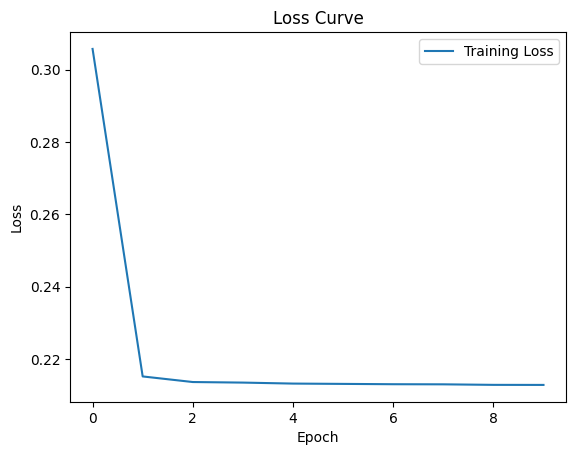

In [ ]:
# plt.plot(history.history['loss'], label='Training Loss')
# plt.title('Loss Curve')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

# Testing

In [17]:
siamese_model.load_weights(checkpoint_path)

In [18]:
decoded_images = siamese_model.predict([X_test[:,0],X_test[:,1]])

25/25 [==============================] - 17s 359ms/step


In [19]:
print(X_test.shape)
print(decoded_images.shape)
print(y_test.shape)

(798, 2, 320, 640, 1)
(798, 320, 640, 1)
(798, 320, 640, 1)


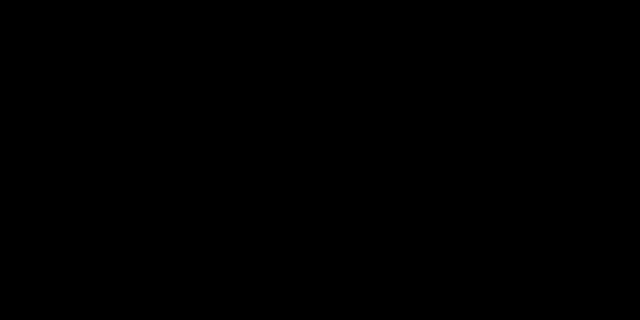

In [22]:
show(X_test[0][0,:])

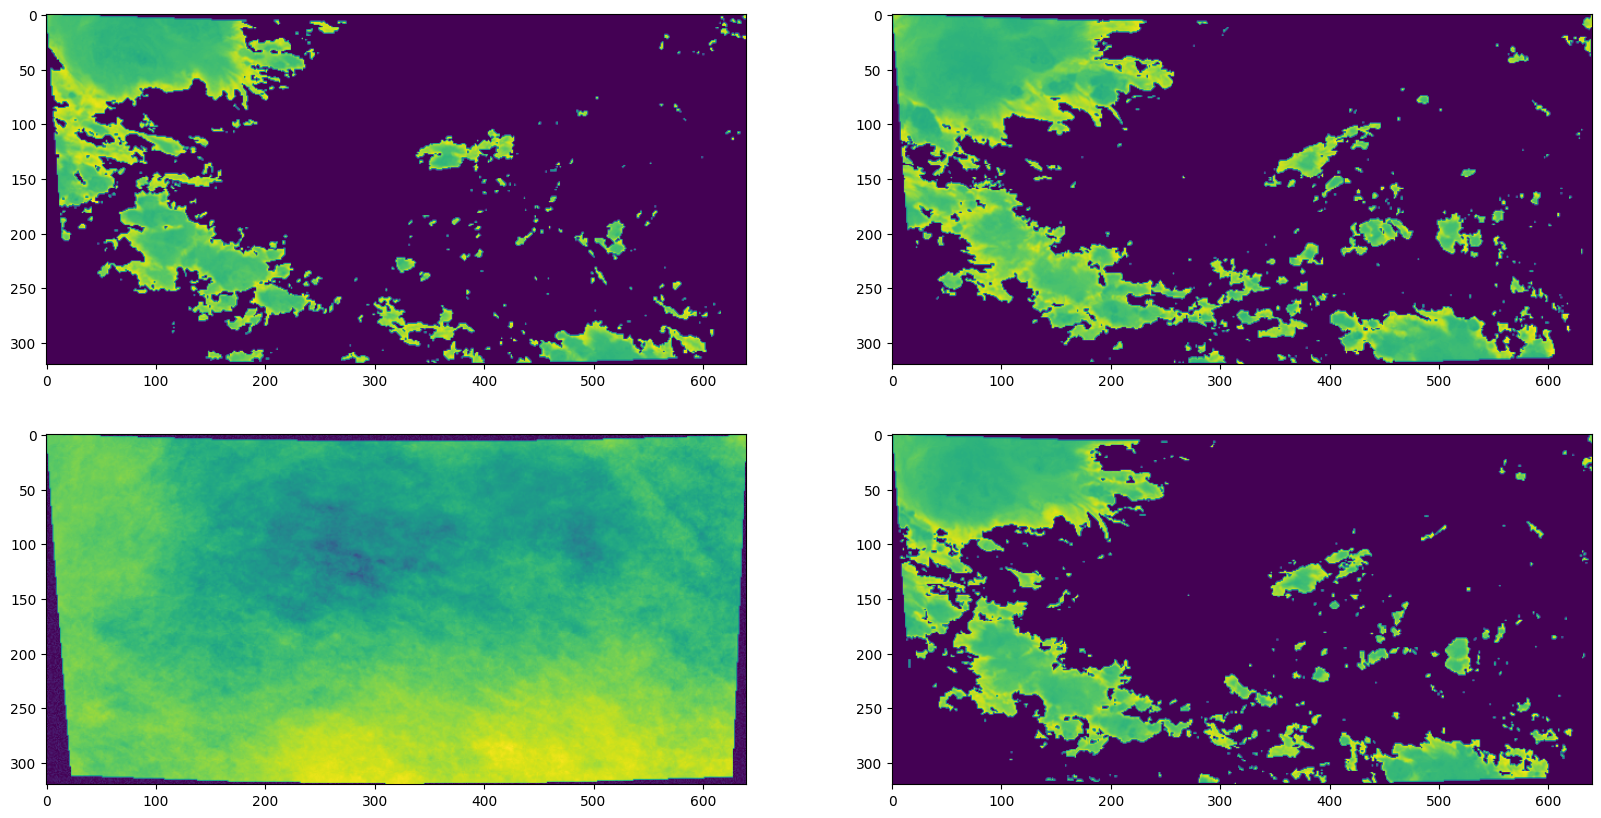

In [24]:
img_index = np.random.randint(0,len(y_test))
plt.figure(figsize=(20,10))
ax = plt.subplot(2,2,1)
plt.imshow(X_test[img_index][0,:])
ax = plt.subplot(2,2,2)
plt.imshow(X_test[img_index][1,:])
ax = plt.subplot(2,2,3)
plt.imshow(decoded_images[img_index])
ax = plt.subplot(2,2,4)
plt.imshow(y_test[img_index])
plt.show()

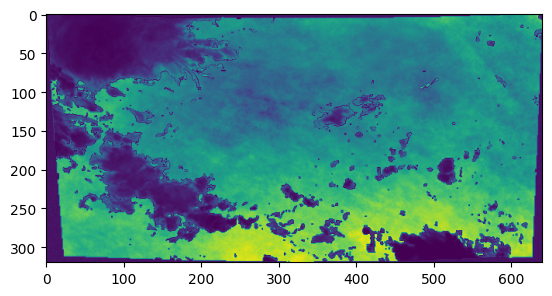

In [25]:
difference = ((decoded_images[img_index][...,0]) - (y_test[img_index].reshape(320,640)))**2
plt.imshow(difference)
plt.show()

In [ ]:
def predict_sequence(model, start_frame, end_frame, num_intermediate_frames, frames):
  first_frame = np.array(start_frame)
  last_frame = np.array(end_frame)
  input_frames = np.expand_dims(np.stack((first_frame, last_frame), axis=2), axis=0)
  middle_frame = np.array(model.predict(input_frames))[0][...,0]

  if (num_intermediate_frames == 1):
    return frames.append(middle_frame)

  else:
    if (num_intermediate_frames % 2 == 1):
      include_middle = True

    else:
      include_middle = False

    predict_sequence(model, start_frame, middle_frame, num_intermediate_frames//2, frames)
    if (include_middle):
      frames.append(middle_frame)
    predict_sequence(model, middle_frame, end_frame, num_intermediate_frames//2, frames)

    return frames

In [ ]:
img_index = np.random.randint(0,len(y_test))
first = data_norm[img_index]
last = data_norm[img_index+4]
predictions = []

predict_sequence(siamese_model, first, last, 4, predictions)

plt.figure(figsize=(20,10))
ax = plt.subplot(2,3,1)
plt.imshow(first)
ax = plt.subplot(2,3,2)
plt.imshow(predictions[0])
ax = plt.subplot(2,3,3)
plt.imshow(predictions[1])
ax = plt.subplot(2,3,4)
plt.imshow(predictions[2])
ax = plt.subplot(2,3,5)
plt.imshow(predictions[3])
ax = plt.subplot(2,3,6)
plt.imshow(last)

plt.show()